In [93]:
from HMM_Functions import get_stock_data
from hmmlearn.hmm import MultinomialHMM
from matplotlib import cm, pyplot as plt
import seaborn
from matplotlib.dates import YearLocator, MonthLocator, DayLocator
import pandas as pd
import numpy 
from datetime import datetime

In [95]:
def sample_from_full_df(df, num_samples):
    print(len(df))
    mod = int(len(df) / num_samples)
    return df[df.index % mod == 0].reset_index()

In [103]:
# Set global constants
NUM_OBSERVATIONS = 60
NUM_COMPONENTS = 6
USE_FULL_SAMPLE = False

In [104]:
# Get the formatted data
# file_name = 'a.us.txt'
file_name = 'biib.us.txt'

stock_df = get_stock_data(file_name)
if USE_FULL_SAMPLE:
    stock_df = sample_from_full_df(stock_df, NUM_OBSERVATIONS)
else:
    stock_df = stock_df[-NUM_OBSERVATIONS:]

In [105]:
def get_emission(stock_dataframe):
    """ Calculates the one day difference between stock closing value (today - yesterday)
        and determines emission symbol based on if stock price increased or decreased from previous day
    
    Args:
        stock_dataframe (dataframe) : dataframe containing stock info(close value, date, high, low, open, etc.)
    
    Returns:
        one_day_dif_df(dataframe) : dataframe containing the difference from the previous day's stock value
                                    as well as the related emission symbol (Increasing or Decreasing)
    """
    
    # Subset the initial DF to obtain only relevant columns
    one_day_dif_df = stock_dataframe.copy()
    one_day_dif_df = one_day_dif_df[['Date','Close']]
    
    # Convert CV to numeric for calculations
    one_day_dif_df['Close'] = pd.to_numeric(one_day_dif_df['Close'])
    one_day_dif_df['Yesterday Close'] = one_day_dif_df['Close'].shift()
    
    # Calculate the stock's closing price difference from the previous day
    one_day_dif_df['Close Value Difference'] = round((one_day_dif_df['Close'] - one_day_dif_df['Yesterday Close']),2)
    
    one_day_dif_df['Emission'] = 'NaN'
    row_indexes_inc = one_day_dif_df[one_day_dif_df['Close Value Difference']>=0].index
    row_indexes_dec = one_day_dif_df[one_day_dif_df['Close Value Difference']<0].index
    
    # Must use 1 and 0 to signify increasing & decreasing since MultinomialHMM .fit(X) can only take positive ints
    one_day_dif_df.loc[row_indexes_inc,'Emission']=int(1)
    one_day_dif_df.loc[row_indexes_dec,'Emission']=int(0)
    #one_day_dif_df['Emission'] = ['Increasing' if x > 0 else 'Decreasing' for x in one_day_dif_df['Close Value Difference']]
    
    return one_day_dif_df

In [106]:
# Add emissions to the dataframe
df_with_emissions = get_emission(stock_df)[1:] # Shift over by one since first emission is NaN
df_with_emissions = df_with_emissions.reset_index()
df_with_emissions

,index,Date,Close,Yesterday Close,Close Value Difference,Emission
0,6527,2017-08-21,283.15,281.77,1.38,1
1,6528,2017-08-22,286.72,283.15,3.57,1
2,6529,2017-08-23,282.64,286.72,-4.08,0
3,6530,2017-08-24,285.45,282.64,2.81,1
4,6531,2017-08-25,285.06,285.45,-0.39,0
5,6532,2017-08-28,292.30,285.06,7.24,1
6,6533,2017-08-29,293.58,292.30,1.28,1
7,6534,2017-08-30,303.75,293.58,10.17,1
8,6535,2017-08-31,316.56,303.75,12.81,1
9,6536,2017-09-01,321.01,316.56,4.45,1


In [107]:
emissions = df_with_emissions['Emission']

# Reshape emissions for training
X = emissions.values.reshape(-1, 1)
X = X.tolist()

In [108]:
def get_random_distribution(size):
    rand_arr = numpy.random.rand(size, size)
    return rand_arr/rand_arr.sum(axis=1, keepdims=True)

In [131]:
# Create a single HMM

print("fitting to HMM and decoding ...", end="")

# Make an HMM instance and execute fit
model = MultinomialHMM(n_components=NUM_COMPONENTS, n_iter=10, params='ste', init_params="e")

# randomize the initial state probabilities
model.startprob_ = [0.16, 0.16, 0.17, 0.17, 0.17, 0.17]

# randomize the initial transition probabilities
# model.transmat_ = get_random_distribution(NUM_COMPONENTS)
model.transmat_ = [[0.3, 0.3, 0.2, 0.1, 0.05, 0.05],
    [0.25, 0.3, 0.25, 0.1, 0.05, 0.05],
    [0.1, 0.1, 0.3, 0.2, 0.2, 0.1],
    [0.1, 0.1, 0.2, 0.3, 0.2, 0.1],
    [0.05, 0.05, 0.1, 0.25, 0.3, 0.25],
    [0.05, 0.05, 0.1, 0.2, 0.3, 0.3]]

# randomize the initial emission probabilities
# model.emissionprob_ = get_random_distribution(NUM_COMPONENTS)
model.emissionprob_ = numpy.array([[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])

# "train" the model
model.fit(X)

# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

print("done")


fitting to HMM and decoding ...done


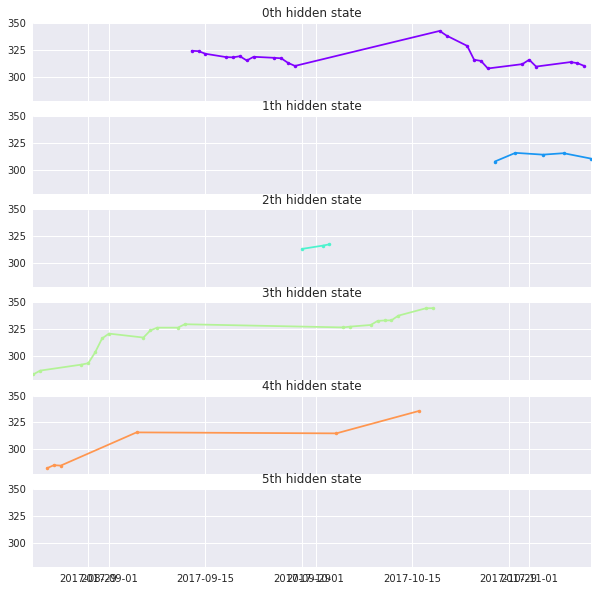

In [129]:
# print("Transition matrix")
# print(model.transmat_)
# print()

dates = df_with_emissions["Date"]
close_v = df_with_emissions["Close"]


fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True)
colours = cm.rainbow(numpy.linspace(0, 1, model.n_components))
for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], close_v[mask], ".-", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)

# set axis
plt.xlim(dates[0], dates[len(dates)-1])

# set y-axis
plt.ylim(numpy.amin(close_v) - 5, numpy.amax(close_v) + 5)

# plt.xlim(1, 10)
fig.set_size_inches(10, 10)
seaborn.set()
plt.show()
